# Introduction

In this guide we will design and train an image recognition model for recognizing 17 different species of flowers. We will use a technique called transfer learning, combining a predefined model called VGG19 trained on ImageNet with our own flower classification subnet. The guide is an extension of the workshop found [here](https://www.tekna.no/kurs/maskinlaringsworkshop---python-36454/), and thus requires some shallow understanding of machine learning theory and programming in Python. Running the code has two prerequisites: 

__A python environment containing tensorflow and keras:__

In [111]:
import tensorflow
import keras

__Downloading and restructuring the dataset in a folder 'flowers' as defined [here](https://github.com/epimedai/flowers/blob/master/README.md):__

In [112]:
import os

print('Root dir exists: {}'.format(os.path.isdir('flowers')))
print('Train dir exists: {}'.format(os.path.isdir(os.path.join('flowers', 'train'))))
print('Validation dir exists: {}'.format(os.path.isdir(os.path.join('flowers', 'val'))))

Root dir exists: True
Train dir exists: True
Validation dir exists: True


# Step 1: Serving images in-memory

To serve images to our model during training we will use a python Generator. Given that our images are structured as previously stated, a folder with the training set and a folder with the validation set, both with subfolders for each category of flowers, we can use a prebuilt keras generator called [ImageDataGenerator](https://keras.io/preprocessing/image/). The generator acts as a list and serves what is known as batches of tuples, where the first element of the tuple contains the images and of the batch and the second element contains the corresponding labels. 

In [159]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator()
batches = generator.flow_from_directory('flowers/train', batch_size=4)

batches

Found 1105 images belonging to 17 classes.


At this point it is usually a good idea to sanity check that everything works as intended. This typically includes verifying that our images are served on the correct format, and that the images and labels are still correctly matched. We can first fetch the reverse encoding of the generator to be able to decode the onehot encoded labels given in the batches

In [114]:
indices = batches.class_indices
labels = [None] * 17

for key in indices:
    labels[indices[key]] = key

labels

['bluebell',
 'buttercup',
 'colts_foot',
 'cowslip',
 'crocus',
 'daffodil',
 'daisy',
 'dandelion',
 'fritillary',
 'iris',
 'lily_valley',
 'pansy',
 'snowdrop',
 'sunflower',
 'tigerlily',
 'tulip',
 'windflower']

We can then use matplotlib to visualize the first batch

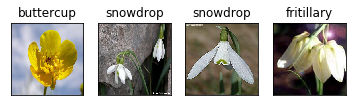

In [115]:
import matplotlib.pyplot as plt
import numpy as np

for X, y in batches:
    fig, ax = plt.subplots(1, 4)
    
    for i in range(len(X)):
        img = X[i].astype(np.uint8)
        label = labels[np.argmax(y[i])]

        ax[i].imshow(img)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    
    plt.show()
    break # We only need the first batch

# Step 2: Setting up the base model

Once we know our dataset is being served correctly we can start setting up the base model that will be the core of our flower classification model. As previously mentioned this will be a model called VGG19, a small model which yields relatively good results. Like the generator, this also exists as a prebuilt module in Keras, namely in the [applications-module](https://keras.io/applications/). 

In [116]:
from keras.applications.vgg19 import VGG19

When initializing the model we need to specify that we want to use the weights trained on ImageNet, that we want the entire model including top layers, and we also specify the image size we are going to use for verbosity. 

In [118]:
model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

We can sanity check this step by running predicting the label for an image from our generator. Note that the predictions we are doing now will be using the labels from ImageNet, as this is what the model currently recognizes, not the labels from our dataset. We start by reinitializing the generator with the correct size and a batch size of 1. We also set the seed for the random library to control the order of the images

In [119]:
np.random.seed(1234)
generator = ImageDataGenerator()
batches = generator.flow_from_directory('flowers/train', target_size=(224, 224), batch_size=1)

Found 1105 images belonging to 17 classes.


We can then run predictions on the first batch containing a single image. To decode the prediction using imagenet labels we can use a predefined function found in the same module as the model

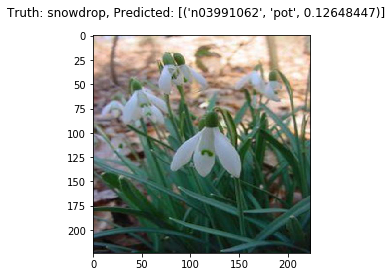

In [120]:
from keras.applications.vgg19 import decode_predictions

for X, y in batches:
    preds = model.predict(X)
    decoded_preds = decode_predictions(preds, top=1)
    fig = plt.figure()
    
    img = X[0].astype(np.uint8)
    label = labels[np.argmax(y[0])]
    predicted = decoded_preds[0]
    
    plt.imshow(img)
    fig.suptitle('Truth: {}, Predicted: {}'.format(label, predicted))
    plt.show()
    
    break

# Step 3: Preprocessing

We now know both our generator and model are set up, and we are able to make predictions. The predictions, however, does not necessarily look very good. This is because of a process called preprocessing: A set of transformations applied to the images before training to give the model the best possible foundation to learn what it needs. Typical preprocessing includes rescaling the values of the data, shifting the range, and other numerical operations. Luckily, in Keras, the module which contains a model also contains the preprocessing function used for training the model. We can fetch this function and feed it to our generator to ensure all images are preprocessed before they are served to the model

In [121]:
from keras.applications.vgg19 import preprocess_input

np.random.seed(1234)
generator = ImageDataGenerator(preprocessing_function=preprocess_input)
batches = generator.flow_from_directory('flowers/train', target_size=(224, 224), batch_size=1)

Found 1105 images belonging to 17 classes.


Once we have reinitialized the generator correctly we can rerun our predictions to see if they improve

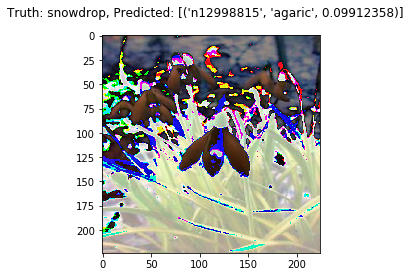

In [122]:
for X, y in batches:
    preds = model.predict(X)
    decoded_preds = decode_predictions(preds, top=1)
    fig = plt.figure()
    
    img = X[0].astype(np.uint8)
    label = labels[np.argmax(y[0])]
    predicted = decoded_preds[0]
    
    plt.imshow(img)
    fig.suptitle('Truth: {}, Predicted: {}'.format(label, predicted))
    plt.show()
    
    break

Note that seeing improvements in the predictions is not a given even though the images are now preprocessed correctly. The label we are looking for might not be a part of the original dataset the model was trained on, or it might simply be a case of a bad prediction where the model misses. However, running a sanity check (preferably over more images) is usually a good habit to achieve the best results.

# Step 4: Configuring the flower classification model

Once our we are happy with the way we are interacting with the base we can start setting up our own custom model for solving the problem we are interested in, in this case classifying flower species. The first step is to be a bit more restrictive with what we use from the pretrained model, only picking out the parts we need. We do this by dropping the top layers used for predictions, and instead perform a pooling operation on the final convolutional layer. Once we have initialized it we can fetch the input and the output of the pretrained model using properties found in keras' model class.

In [123]:
pretrained = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='max')
inputs = pretrained.input
outputs = pretrained.output

As we do not want the weights in this part of the final model to change, we can freeze them

In [124]:
for layer in pretrained.layers:
    layer.trainable = False

We can then create our own custom layers for performing our own task. We will use a hidden fully connected layer with 128 neurons, and a final prediction layer with 17 neurons, one per specie in our dataset. Note that the hidden layer takes the output from the pretrained model as its input.

In [125]:
from keras.layers import Dense

hidden = Dense(128, activation='relu')(outputs)
preds = Dense(17, activation='softmax')(hidden)

Once we have all our layers set up we can wrap them in a Model, and compile the model using a pretty standardized set of hyperparameters.

In [126]:
from keras.engine import Model
from keras.optimizers import Adam

model = Model(inputs, preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])

We can then set up generators like we did before, one for the training data and one for validation, and train the model using fit_generator. Note that training here is set to a single epoch simply for example purposes

In [ ]:
np.random.seed(1234)

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_batches = train_generator.flow_from_directory('flowers/train', target_size=(224, 224))

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_batches = val_generator.flow_from_directory('flowers/val', target_size=(224, 224))

model.fit_generator(train_batches, epochs=1, validation_data=val_batches)

# Step 5: Regularization

If you run the training above for a larger number of epochs, you will typically achieve a very decent result on the training data and a considerably worse outcome on the validation data. This is an example of overfitting: The model starts remembering specifics from the training set instead of learning the general features we are interested in. We handle this by introducing regularization, trying to force the model to generalize. In image recognition this is typically done using dropout-layers, which during training randomly sets the firing of a subset of neurons to 0. We can introduce dropout to our model by inserting a Dropout layer which drops 30% of the neurons between the two final layers of our model.

In [ ]:
from keras.layers import Dropout

hidden = Dense(128, activation='relu')(outputs)
dropout = Dropout(.3)(hidden)
preds = Dense(17, activation='softmax')(dropout)

We can recompile the model and restart training to achieve what should be a better result

In [ ]:
model = Model(inputs, preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])

np.random.seed(1234)

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_batches = train_generator.flow_from_directory('flowers/train', target_size=(224, 224))

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_batches = val_generator.flow_from_directory('flowers/val', target_size=(224, 224))

model.fit_generator(train_batches, epochs=1, validation_data=val_batches)

# Step 6: Augmentations

A second technique for avoiding overfitting is augmenting the image, which goal it is to take the existing data points in our dataset and create brand new samples. It works by somehow modifying an image in a way which changes it, while maintaining the thruthfulness of the corresponding image. An example in our case is mirroring the images vertically, which can be implemented directly in the keras generator

In [161]:
np.random.seed(1234)

generator = ImageDataGenerator(horizontal_flip=True)
batches = generator.flow_from_directory('flowers/train', batch_size=1, shuffle=False)

Found 1105 images belonging to 17 classes.


Using this functionality will randomly decide whether to flip the image or not each time the image is presented, theoretically yielding two samples from the single data point we started with. We can see this by visualizing the same image served from multiple batches

Found 1105 images belonging to 17 classes.
Found 1105 images belonging to 17 classes.
Found 1105 images belonging to 17 classes.
Found 1105 images belonging to 17 classes.
Found 1105 images belonging to 17 classes.


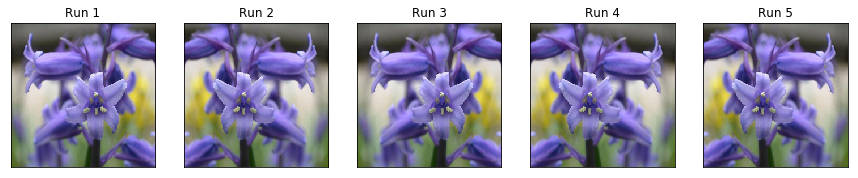

In [163]:
fig, ax = plt.subplots(1, 5, figsize=(15, 10))

for i in range(5):
    batches = generator.flow_from_directory('flowers/train', batch_size=1, shuffle=False)
    for X, y in batches:
        ax[i].imshow(X[0].astype(np.uint8))
        ax[i].set_title('Run {}'.format(i + 1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        break

plt.show()

# Summary

The steps in this guide provide a solid baseline for classifying species of flowers, or solving any other generic image classification problem. Retracing the steps while leaving more epochs for the model to train should provide a solid baseline with decent results (my best run achieved x%). Continued work on this problem would typically include trying different architectures as core models, experimenting with various designs for the custom problem-specific final layers and testing a wide range of combinations of regularization and augmentations to combat overfitting. It should be a feasible goal to reach an accuracy in the high 90s, which seem to be what state-of-the-art models are performing. Happy hacking!